In [1]:
%reset

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pe
import build_data
from build_data import ext_pyomo_vals
import model as m
import seaborn as sns
import pandas as pd
import os

In [3]:
_import_factor = 400
_stor_factor = 300
_specific_date='2019-07-10'
#Dia 15 é o dia com o maior valor de metrica01
#01 é o dia com menor erro de forecast de carga 
#21 é o dia com maior erro de forecast de carga

In [4]:
#Build forecat data
Data_forecast = build_data.Data()
Data_forecast.increase_import_limit(factor=_import_factor)
Data_forecast.get_gen_forecast_data_from_db(specific_date=_specific_date)
Data_forecast.get_loads_forecast_data_from_db(specific_date=_specific_date)
Data_forecast.increase_storage_capacity(factor=_stor_factor)

In [5]:
model_forecast = m.creat_model(Data_forecast.get_data())

model_forecast = m.def_import_export( Data_forecast.get_data(), model_forecast)
model_forecast = m.def_gen(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_loads(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_storage(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_v2g(Data_forecast.get_data(), model_forecast)
model_forecast = m.def_charging_stations(Data_forecast.get_data(), model_forecast)

model_forecast.balanceEq = pe.Constraint(model_forecast.t, rule=m._balanceEq,
                                doc='Balance equation')

model_forecast.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

In [6]:
model_forecast.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_forecast = pe.SolverFactory('scip', executable='C:/Program Files/SCIPOptSuite 8.0.3/bin/scip.exe')
solver_forecast.options['LogFile'] = 'res_community.log'

results_forecast = solver_forecast.solve(model_forecast)
# results_forecast.write()
objective_value = pe.value(model_forecast.objFn)
print(f"The value of the objective function is: {objective_value}")

The value of the objective function is: 77982.26945485789


In [7]:
#  Result extraction

# Generation
result_genActPower_forecast = ext_pyomo_vals(model_forecast.genActPower)
result_genExcActPower_forecast = ext_pyomo_vals(model_forecast.genExcPower)

# Imports/Exports
result_pimp_forecast = ext_pyomo_vals(model_forecast.imports)
result_pexp_forecast = ext_pyomo_vals(model_forecast.exports)

# Loads
result_loadRedActPower_forecast = ext_pyomo_vals(model_forecast.loadRedActPower)
result_loadCutActPower_forecast = ext_pyomo_vals(model_forecast.loadCutActPower)
result_loadENS_forecast = ext_pyomo_vals(model_forecast.loadENS)

# Storage
result_storDchActPower_forecast = ext_pyomo_vals(model_forecast.storDischarge)
result_storChActPower_forecast = ext_pyomo_vals(model_forecast.storCharge)
result_storEnerState_forecast = ext_pyomo_vals(model_forecast.storState)

# V2G
result_v2gDchActPower_forecast = ext_pyomo_vals(model_forecast.v2gDischarge)
result_v2gChActPower_forecast = ext_pyomo_vals(model_forecast.v2gCharge)
result_v2gEnerState_forecast = ext_pyomo_vals(model_forecast.v2gState)

# Charging Stations
result_csActPower_forecast = ext_pyomo_vals(model_forecast.csCharge)
result_csActPowerNet_forecast = ext_pyomo_vals(model_forecast.csNetCharge)

# Booleans
result_genXo_forecast = ext_pyomo_vals(model_forecast.genXo)
result_loadXo_forecast = ext_pyomo_vals(model_forecast.loadXo)
result_storDchXo_forecast = ext_pyomo_vals(model_forecast.storDchXo)
result_storChXo_forecast = ext_pyomo_vals(model_forecast.storChXo)
result_v2gDchXo_forecast = ext_pyomo_vals(model_forecast.v2gDchXo)
result_v2gChXo_forecast = ext_pyomo_vals(model_forecast.v2gChXo)

In [8]:
schedule_storageCh =  np.array(result_storChActPower_forecast)
schedule_storageDch =  np.array(result_storDchActPower_forecast)
schedule_v2gCh =  np.array(result_v2gChActPower_forecast)
schedule_v2gDch =  np.array(result_v2gDchActPower_forecast)

In [9]:
True_Data = build_data.Data()
True_Data.increase_import_limit(factor=_import_factor)
True_Data.get_gen_data_from_db(specific_date=_specific_date)
True_Data.get_loads_data_from_db(specific_date=_specific_date)
True_Data.increase_storage_capacity(factor=_stor_factor)

In [10]:
model_true = m.creat_model(True_Data.get_data())

model_true = m.def_import_export( True_Data.get_data(), model_true)
model_true = m.def_gen(True_Data.get_data(), model_true)
model_true = m.def_loads(True_Data.get_data(), model_true)
model_true = m.def_storage(True_Data.get_data(), model_true, forecast=False, schedule_storageCh=schedule_storageCh, schedule_storageDch=schedule_storageDch)
model_true = m.def_v2g(True_Data.get_data(), model_true, forecast=False, schedule_v2gCh=schedule_v2gCh, schedule_v2gDch=schedule_v2gDch)
model_true = m.def_charging_stations(True_Data.get_data(), model_true)

model_true.balanceEq = pe.Constraint(model_true.t, rule=m._balanceEq,
                                doc='Balance equation')
model_true.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

model_true.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_true = pe.SolverFactory('scip', executable='C:/Program Files/SCIPOptSuite 8.0.3/bin/scip.exe')
solver_true.options['LogFile'] = 'res_community.log'

results_true = solver_true.solve(model_true)
# results_true.write()
objective_value = pe.value(model_true.objFn)
print(f"The value of the objective function is: {objective_value}")

The value of the objective function is: 332664.9387093178


In [11]:
#  Result extraction

# Generation
result_genActPower_true = ext_pyomo_vals(model_true.genActPower)
result_genExcActPower_true = ext_pyomo_vals(model_true.genExcPower)

# Imports/Exports
result_pimp_true = ext_pyomo_vals(model_true.imports)
result_pexp_true = ext_pyomo_vals(model_true.exports)

# Loads
result_loadRedActPower_true = ext_pyomo_vals(model_true.loadRedActPower)
result_loadCutActPower_true = ext_pyomo_vals(model_true.loadCutActPower)
result_loadENS_true = ext_pyomo_vals(model_true.loadENS)

# Storage
result_storDchActPower_true = ext_pyomo_vals(model_true.storDischarge)
result_storChActPower_true = ext_pyomo_vals(model_true.storCharge)
result_storEnerState_true = ext_pyomo_vals(model_true.storState)

# V2G
result_v2gDchActPower_true = ext_pyomo_vals(model_true.v2gDischarge)
result_v2gChActPower_true = ext_pyomo_vals(model_true.v2gCharge)
result_v2gEnerState_true = ext_pyomo_vals(model_true.v2gState)

# Charging Stations
result_csActPower_true = ext_pyomo_vals(model_true.csCharge)
result_csActPowerNet_true = ext_pyomo_vals(model_true.csNetCharge)

# Booleans
result_genXo_true = ext_pyomo_vals(model_true.genXo)
result_loadXo_true = ext_pyomo_vals(model_true.loadXo)
result_storDchXo_true = ext_pyomo_vals(model_true.storDchXo)
result_storChXo_true = ext_pyomo_vals(model_true.storChXo)
result_v2gDchXo_true = ext_pyomo_vals(model_true.v2gDchXo)
result_v2gChXo_true = ext_pyomo_vals(model_true.v2gChXo)

In [12]:
np.max(np.array(ext_pyomo_vals(model_true.v2gScheduleDchRelax)))

0.0

Model has the following attributes:
file_path
data
ec_id
generator
load
storage
charging_station
peers
vehicle


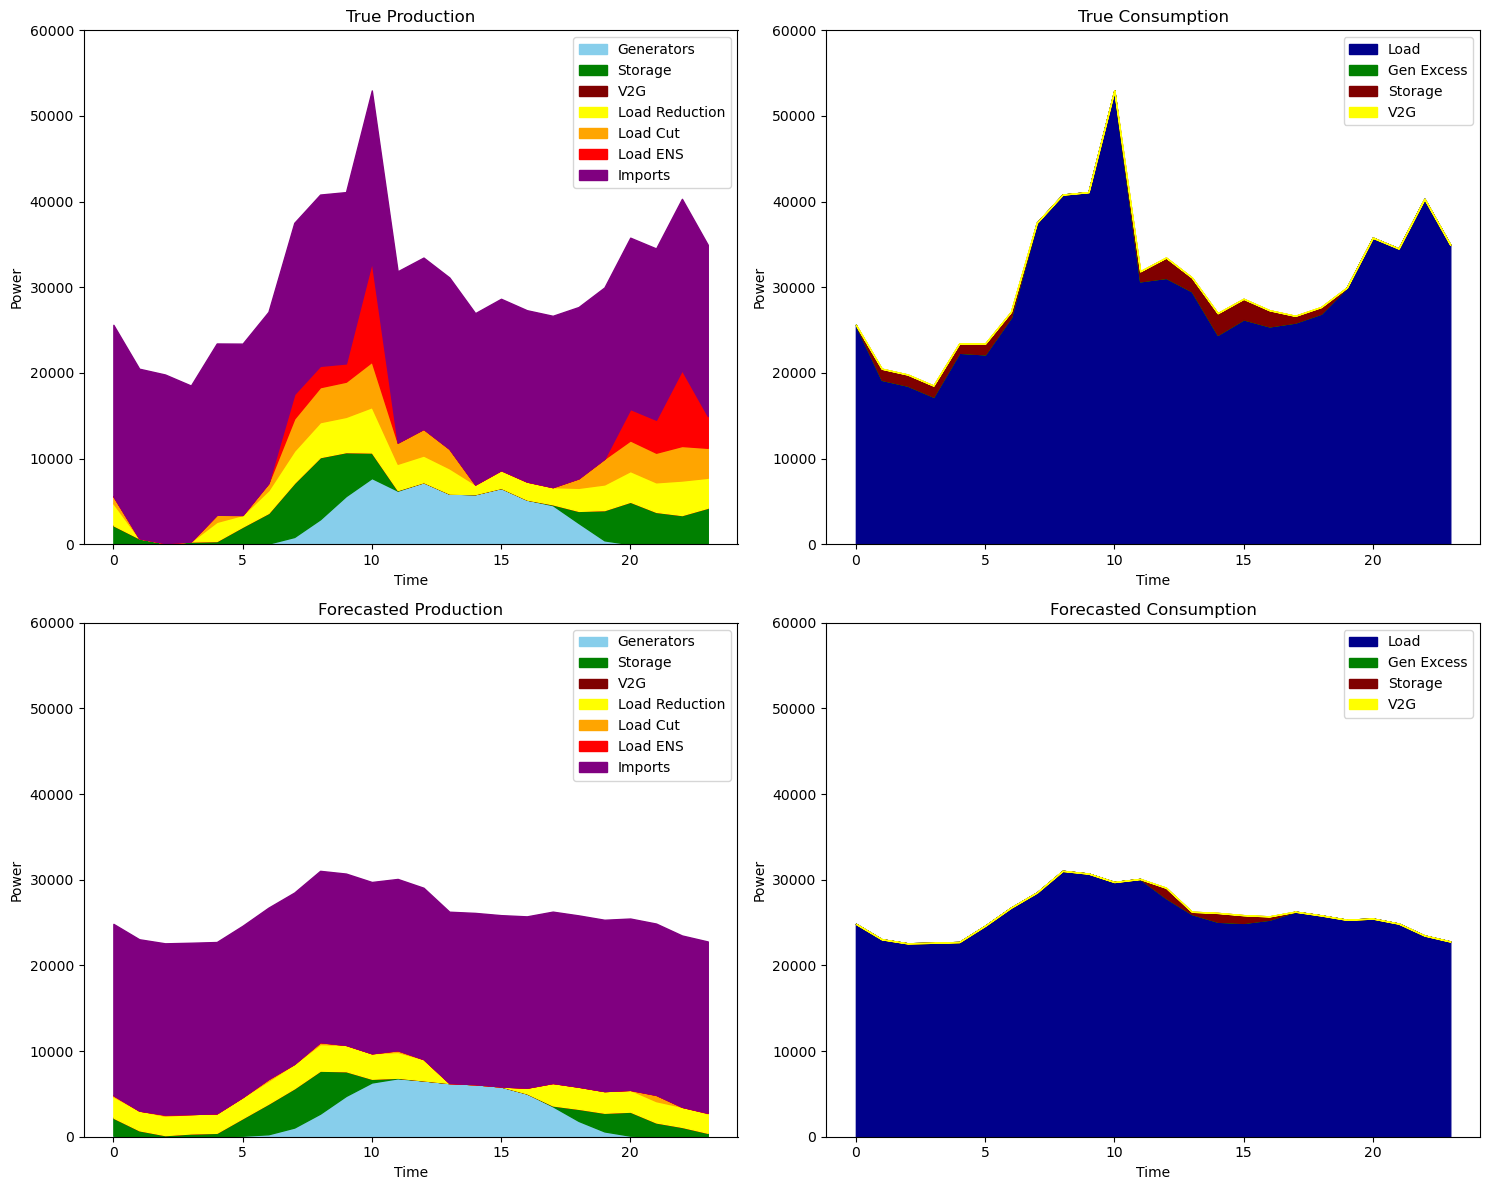

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# True Production
y1 = sum([result_genActPower_true.values[i].astype(float) for i in range(model_true.gen.last())]) 
y2 = sum([result_storDchActPower_true.values[i] for i in range(model_true.stor.last())])
y3 = sum([result_v2gDchActPower_true.values[i] for i in range(model_true.v2g.last())])
y4 = sum([result_loadRedActPower_true.values[i] for i in range(model_true.loads.last())])
y5 = sum([result_loadCutActPower_true.values[i] for i in range(model_true.loads.last())])
y6 = sum([result_loadENS_true.values[i] for i in range(model_true.loads.last())])
y7 = result_pimp_true.values.reshape(24)

axs[0, 0].fill_between(list(range(len(y1))), np.zeros(len(y1)), y1, color='skyblue', label="Generators")
axs[0, 0].fill_between(list(range(len(y2))), y1, y1+y2, color='green', label="Storage")
axs[0, 0].fill_between(list(range(len(y3))), y1+y2, y1+y2+y3, color='maroon', label="V2G")
axs[0, 0].fill_between(list(range(len(y4))), y1+y2+y3, y1+y2+y3+y4, color='yellow', label="Load Reduction")
axs[0, 0].fill_between(list(range(len(y5))), y1+y2+y3+y4, y1+y2+y3+y4+y5, color='orange', label="Load Cut")
axs[0, 0].fill_between(list(range(len(y6))), y1+y2+y3+y4+y5, y1+y2+y3+y4+y5+y6, color='red', label="Load ENS")
axs[0, 0].fill_between(list(range(len(y7))), y1+y2+y3+y4+y5+y6, y1+y2+y3+y4+y5+y6+y7, color='purple', label="Imports")
axs[0, 0].set_ylim(0, 60000)
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Power')
axs[0, 0].set_title('True Production')
axs[0, 0].legend()
Data_forecast.print_data_attributes()
# True Consumption
y1 = np.sum(True_Data.get_data().load['p_forecast'][:, :]*5, axis=0, dtype=np.float64)
y2 = sum([result_genExcActPower_true.values[i] for i in range(model_true.gen.last())])
y3 = sum([result_storChActPower_true.values[i] for i in range(model_true.stor.last())])
y4 = sum([result_v2gChActPower_true.values[i] for i in range(model_true.v2g.last())])

axs[0, 1].fill_between(list(range(len(y1))), np.zeros(len(y1)), y1, color='darkblue', label="Load")
axs[0, 1].fill_between(list(range(len(y2))), y1, y1+y2, color='green', label="Gen Excess")
axs[0, 1].fill_between(list(range(len(y3))), y1+y2, y1+y2+y3, color='maroon', label="Storage")
axs[0, 1].fill_between(list(range(len(y4))), y1+y2+y3, y1+y2+y3+y4, color='yellow', label="V2G")
axs[0, 1].set_ylim(0, 60000)
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Power')
axs[0, 1].set_title('True Consumption')
axs[0, 1].legend()

# Forecasted Production
y1 = sum([result_genActPower_forecast.values[i].astype(float) for i in range(5)]) 
y2 = sum([result_storDchActPower_forecast.values[i] for i in range(3)])
y3 = sum([result_v2gDchActPower_forecast.values[i] for i in range(5)])
y4 = sum([result_loadRedActPower_forecast.values[i] for i in range(5)])
y5 = sum([result_loadCutActPower_forecast.values[i] for i in range(5)])
y6 = sum([result_loadENS_forecast.values[i] for i in range(5)])
y7 = result_pimp_forecast.values.reshape(24)

axs[1, 0].fill_between(list(range(len(y1))), np.zeros(len(y1)), y1, color='skyblue', label="Generators")
axs[1, 0].fill_between(list(range(len(y2))), y1, y1+y2, color='green', label="Storage")
axs[1, 0].fill_between(list(range(len(y3))), y1+y2, y1+y2+y3, color='maroon', label="V2G")
axs[1, 0].fill_between(list(range(len(y4))), y1+y2+y3, y1+y2+y3+y4, color='yellow', label="Load Reduction")
axs[1, 0].fill_between(list(range(len(y5))), y1+y2+y3+y4, y1+y2+y3+y4+y5, color='orange', label="Load Cut")
axs[1, 0].fill_between(list(range(len(y6))), y1+y2+y3+y4+y5, y1+y2+y3+y4+y5+y6, color='red', label="Load ENS")
axs[1, 0].fill_between(list(range(len(y7))), y1+y2+y3+y4+y5+y6, y1+y2+y3+y4+y5+y6+y7, color='purple', label="Imports")
axs[1, 0].set_ylim(0, 60000)
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Power')
axs[1, 0].set_title('Forecasted Production')
axs[1, 0].legend()

# Forecasted Consumption
y1 = np.sum(Data_forecast.get_data().load['p_forecast'][:, :]*5, axis=0, dtype=np.float64)
y2 = sum([result_genExcActPower_forecast.values[i] for i in range(5)])
y3 = sum([result_storChActPower_forecast.values[i] for i in range(3)])
y4 = sum([result_v2gChActPower_forecast.values[i] for i in range(5)])

axs[1, 1].fill_between(list(range(len(y1))), np.zeros(len(y1)), y1, color='darkblue', label="Load")
axs[1, 1].fill_between(list(range(len(y2))), y1, y1+y2, color='green', label="Gen Excess")
axs[1, 1].fill_between(list(range(len(y3))), y1+y2, y1+y2+y3, color='maroon', label="Storage")
axs[1, 1].fill_between(list(range(len(y4))), y1+y2+y3, y1+y2+y3+y4, color='yellow', label="V2G")
axs[1, 1].set_ylim(0, 60000)
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Power')
axs[1, 1].set_title('Forecasted Consumption')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

The value of the objective function is: 182013.5038862923


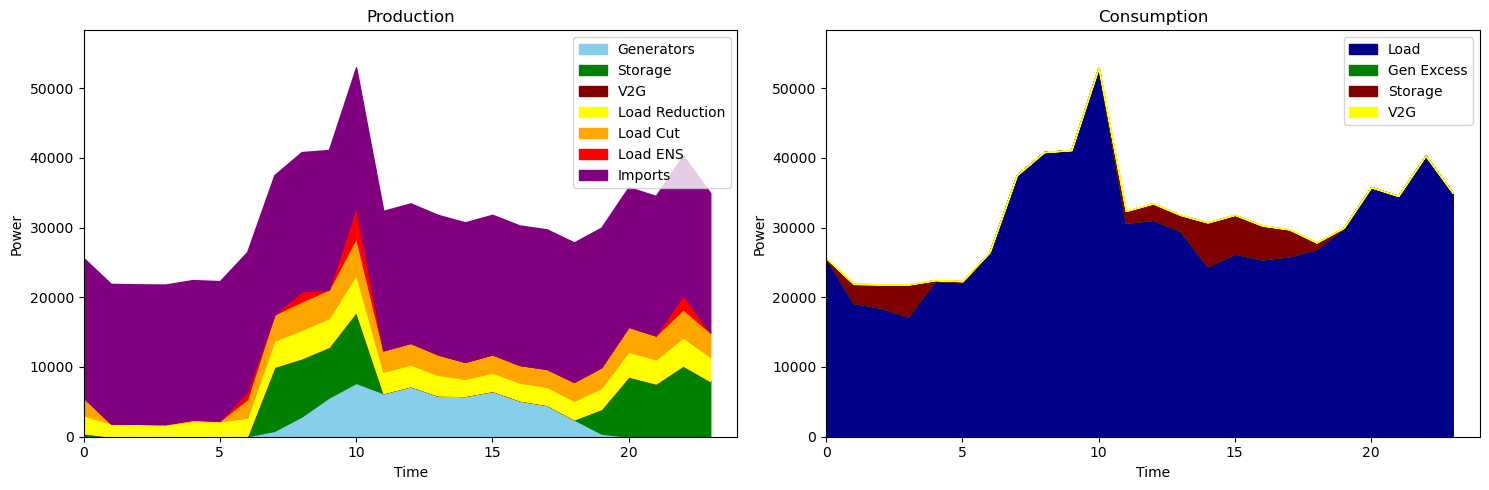

In [14]:
model_true_true = m.creat_model(True_Data.get_data())

model_true_true = m.def_import_export( True_Data.get_data(), model_true_true)
model_true_true = m.def_gen(True_Data.get_data(), model_true_true)
model_true_true = m.def_loads(True_Data.get_data(), model_true_true)
model_true_true = m.def_storage(True_Data.get_data(), model_true_true, forecast=True)
model_true_true = m.def_v2g(True_Data.get_data(), model_true_true, forecast=True)
model_true_true = m.def_charging_stations(True_Data.get_data(), model_true_true)

model_true_true.balanceEq = pe.Constraint(model_true_true.t, rule=m._balanceEq,
                                doc='Balance equation')
model_true_true.objFn = pe.Objective(rule=m._objFn, sense=pe.minimize,
                           doc='Objective function')

model_true_true.write('res_community.lp', io_options={'symbolic_solver_labels': True})

# Solve the model
solver_true_true = pe.SolverFactory('scip', executable='C:/Program Files/SCIPOptSuite 8.0.3/bin/scip.exe')
solver_true_true.options['LogFile'] = 'res_community.log'

results_true_true = solver_true.solve(model_true_true)
# results_true.write()
objective_value = pe.value(model_true_true.objFn)
print(f"The value of the objective function is: {objective_value}")

#  Result extraction

# Generation
result_genActPower_true_true = ext_pyomo_vals(model_true_true.genActPower)
result_genExcActPower_true_true = ext_pyomo_vals(model_true_true.genExcPower)

# Imports/Exports
result_pimp_true_true = ext_pyomo_vals(model_true_true.imports)
result_pexp_true_true = ext_pyomo_vals(model_true_true.exports)

# Loads
result_loadRedActPower_true_true = ext_pyomo_vals(model_true_true.loadRedActPower)
result_loadCutActPower_true_true = ext_pyomo_vals(model_true_true.loadCutActPower)
result_loadENS_true_true = ext_pyomo_vals(model_true_true.loadENS)

# Storage
result_storDchActPower_true_true = ext_pyomo_vals(model_true_true.storDischarge)
result_storChActPower_true_true = ext_pyomo_vals(model_true_true.storCharge)
result_storEnerState_true_true = ext_pyomo_vals(model_true_true.storState)

# V2G
result_v2gDchActPower_true_true = ext_pyomo_vals(model_true_true.v2gDischarge)
result_v2gChActPower_true_true = ext_pyomo_vals(model_true_true.v2gCharge)
result_v2gEnerState_true_true = ext_pyomo_vals(model_true_true.v2gState)

# Charging Stations
result_csActPower_true_true = ext_pyomo_vals(model_true_true.csCharge)
result_csActPowerNet_true_true = ext_pyomo_vals(model_true_true.csNetCharge)

# Booleans
result_genXo_true_true = ext_pyomo_vals(model_true_true.genXo)
result_loadXo_true_true = ext_pyomo_vals(model_true_true.loadXo)
result_storDchXo_true_true = ext_pyomo_vals(model_true_true.storDchXo)
result_storChXo_true_true = ext_pyomo_vals(model_true_true.storChXo)
result_v2gDchXo_true_true = ext_pyomo_vals(model_true_true.v2gDchXo)
result_v2gChXo_true_true = ext_pyomo_vals(model_true_true.v2gChXo)

m.plot_profile(result_genActPower=result_genActPower_true_true, result_storDchActPower = result_storDchActPower_true_true,
               result_v2gDchActPower=result_v2gDchActPower_true_true, result_loadRedActPower=result_loadRedActPower_true_true,
               result_loadCutActPower=result_loadCutActPower_true_true, result_loadENS=result_loadENS_true_true,
               result_pimp=result_pimp_true_true, model = model_true_true, Data = True_Data, result_genExcActPower=result_genExcActPower_true_true,
               result_storChActPower=result_storChActPower_true_true, result_v2gChActPower=result_v2gChActPower_true_true)

(14, 24)


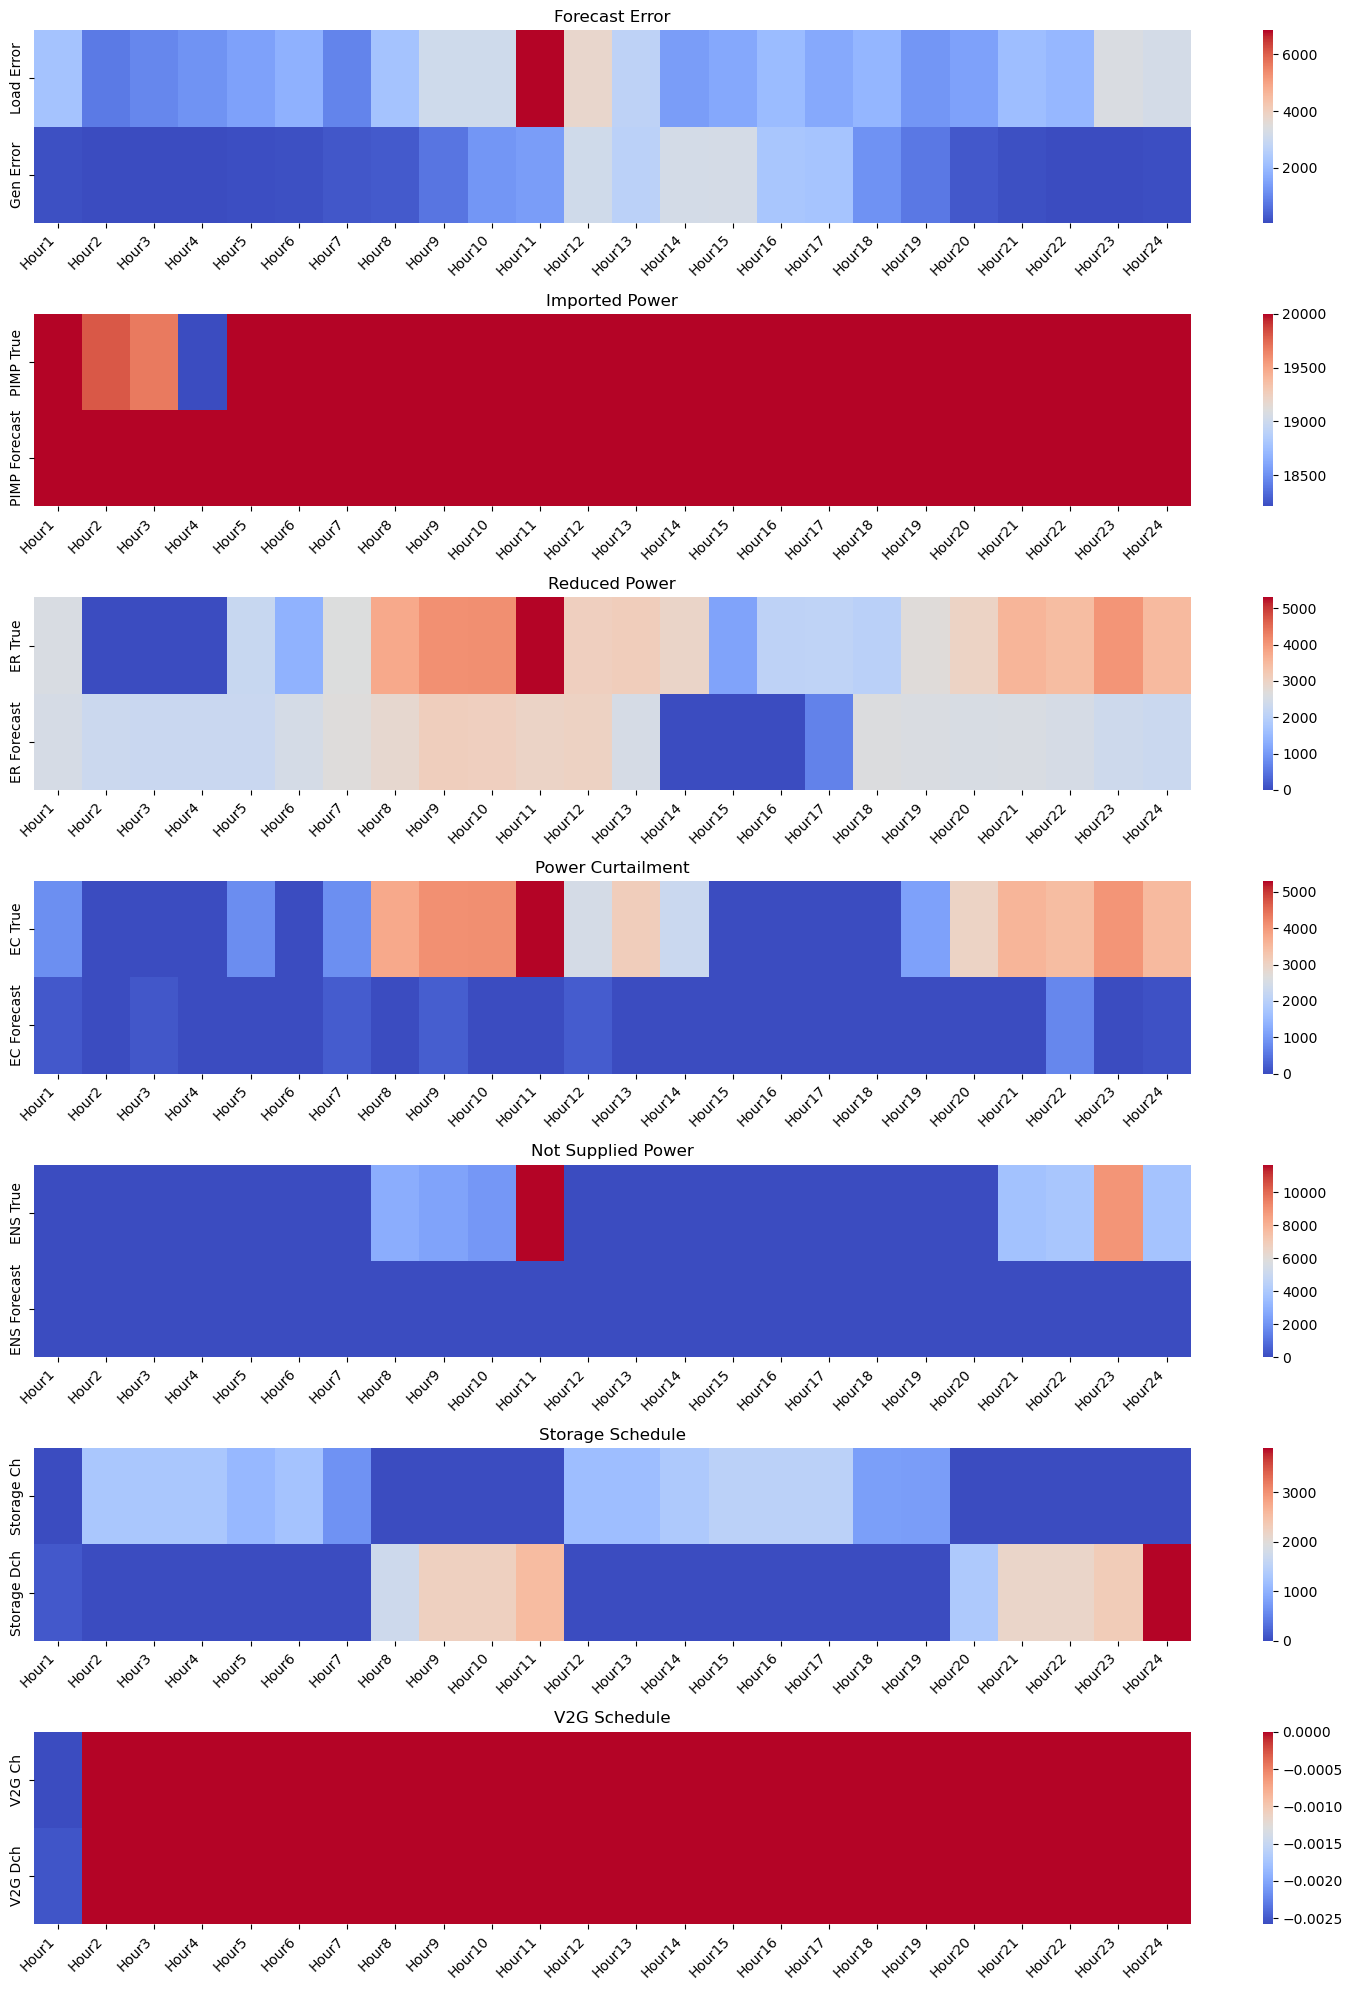

In [15]:
forecast_error_load = np.abs(Data_forecast.get_data().load['p_forecast'][:, :] - True_Data.get_data().load['p_forecast'][:, :])
forecast_error_gen = np.abs(Data_forecast.get_data().generator['p_forecast'][:, :] - True_Data.get_data().generator['p_forecast'][:, :])
data = np.vstack([[np.sum(forecast_error_load, axis = 0, dtype=np.float64).reshape(-1, 1)],
                  [np.sum(forecast_error_gen, axis = 0, dtype=np.float64).reshape(-1, 1)],
                  [result_pimp_true], [result_pimp_forecast],
                  [np.sum(np.array(result_loadRedActPower_true), axis = 0).reshape(-1, 1)], [np.sum(np.array(result_loadRedActPower_forecast), axis = 0).reshape(-1, 1)],
                  [np.sum(np.array(result_loadCutActPower_true), axis = 0).reshape(-1, 1)], [np.sum(np.array(result_loadCutActPower_forecast), axis = 0).reshape(-1, 1)],
                  [np.sum(np.array(result_loadENS_true), axis = 0).reshape(-1, 1)], [np.sum(np.array(result_loadENS_forecast), axis = 0).reshape(-1, 1)],
                  [np.sum(np.array(ext_pyomo_vals(model_true.v2gScheduleChRelax)), axis = 0).reshape(-1, 1)], [np.sum(np.array(ext_pyomo_vals(model_true.v2gScheduleDchRelax)), axis = 0).reshape(-1, 1)],
                  [np.sum(np.array(ext_pyomo_vals(model_true.storScheduleChRelax)), axis = 0).reshape(-1, 1)], [np.sum(np.array(ext_pyomo_vals(model_true.storScheduleDchRelax)), axis = 0).reshape(-1, 1)]]
                 ).squeeze()
print(data.shape)
df = pd.DataFrame(data, index=['Load Error', 'Gen Error', 'PIMP True', 'PIMP Forecast', 'ER True', 'ER Forecast', 'EC True', 'EC Forecast', 'ENS True', 'ENS Forecast', 'V2G Ch', 'V2G Dch', 'Storage Ch', 'Storage Dch'], columns=[f'Hour{i}' for i in range(1, 25)])

fig, ax = plt.subplots(7, 1, figsize=(15, 20), gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2, 2]})

# Plot the first row with one colormap
sns.heatmap(df.iloc[0:2], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[0])
ax[0].set_title('Forecast Error')

# Plot the next two rows with another colormap
sns.heatmap(df.iloc[2:4], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[1])
ax[1].set_title('Imported Power')

sns.heatmap(df.iloc[4:6], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[2])
ax[2].set_title('Reduced Power')

sns.heatmap(df.iloc[6:8], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[3])
ax[3].set_title('Power Curtailment')

sns.heatmap(df.iloc[8:10], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[4])
ax[4].set_title('Not Supplied Power')

sns.heatmap(df.iloc[12:14], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[5])
ax[5].set_title('Storage Schedule')

sns.heatmap(df.iloc[10:12], annot=False, fmt=".2f", cmap='coolwarm', cbar=True, ax=ax[6])
ax[6].set_title('V2G Schedule')
# Hide the axes for a cleaner look
for a in ax:
    a.set_yticklabels(a.get_yticklabels(), rotation=90)
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [16]:
metric02 = m.metric02(np.array(result_pimp_true_true), np.array(result_pimp_true), np.array(result_loadRedActPower_true_true), np.array(result_loadRedActPower_true),
           np.array(result_loadCutActPower_true_true), np.array(result_loadCutActPower_true), np.array(result_loadENS_true_true), np.array(result_loadENS_true),
           a = 0.1, b = 0.2, c = 0.5, d = 0)

print(f"The value of the metric is: {metric02}")

The value of the metric is: 2335.89698003582


In [17]:

# dataaaaaa = np.vstack([_specific_date,
#                        np.sum(forecast_error_load, dtype=np.float64).reshape(-1, 1),
#                        np.sum(forecast_error_gen, dtype=np.float64).reshape(-1, 1),
#                        metric01]).T

# df = pd.DataFrame(dataaaaaa, columns=['Date', 'Load Error', 'Gen Error', 'Metric01'])

# file_path = 'dayly_metrics.xlsx'

# print(df)
# if os.path.exists(file_path):
#         existing_data = pd.read_excel(file_path)
#         combined_data = pd.concat([existing_data, df]).drop_duplicates(subset=['Date'], keep='last')
# else:
#     combined_data = df
# combined_data.to_excel(file_path, index=False)

In [18]:
# excel_file = 'hourly_metrics.xlsx'
# newdf = df.T
# newdf.insert(0, 'Date', _specific_date)
# newdf.insert(1, 'Hour', list(range(1, 25)))
# # Function to append new data if it doesn't exist
# def append_data_to_excel(new_data, file_path):
#     if os.path.exists(file_path):
#         existing_data = pd.read_excel(file_path)
#         combined_data = pd.concat([existing_data, new_data]).drop_duplicates(subset=['Date', 'Hour'], keep='last')
#     else:
#         combined_data = new_data
#     combined_data.to_excel(file_path, index=False)

# append_data_to_excel(newdf, excel_file)


         Date    Load Error     Gen Error      Metric01
0  2019-07-01  37636.332911  26421.826336    105.162329
1  2019-07-02  82130.991104  26511.334330  14800.123769
2  2019-07-03  41502.268551  20754.572826  62945.156086
3  2019-07-05  56673.676298  19476.371593   1383.739926
4  2019-07-07  58214.607845  23436.769391   3993.260025


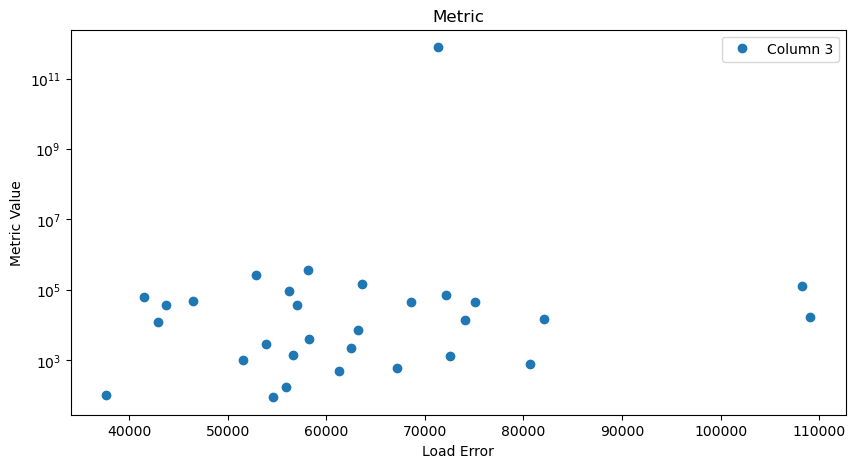

In [19]:
file_path = 'dayly_metric02.xlsx'

df = pd.read_excel(file_path)
print(df.head())

load_error = df.iloc[:, 1]
metric = df.iloc[:, 3]

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(load_error, metric,'o', label='Column 3')
plt.yscale('log')
plt.xlabel('Load Error')
plt.ylabel('Metric Value')
plt.title('Metric')
plt.legend()
plt.show()

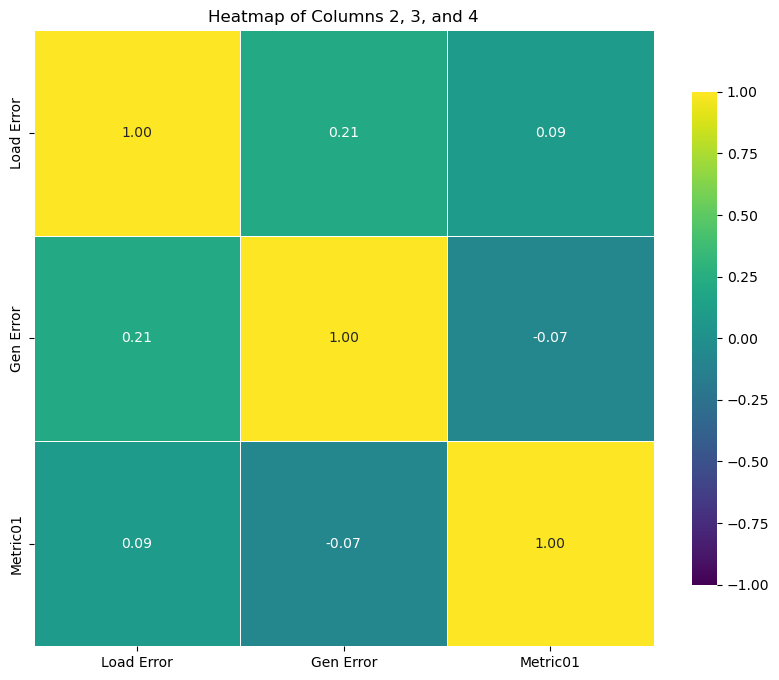

In [20]:
data = df.iloc[:, 1:4]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5, vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title('Heatmap of Columns 2, 3, and 4')
plt.show()